Copyright (c) 2022, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

# Multi-step Principal-Agent (multiple Agents) wage optimization

This notebook serves as a reference for running the training pipeline for the wage schedule optimization problem in the multi-step + multi-Agent + multi-channel setting -- where each round the principal selects the wage for each agent and each agent chooses how much and how hard to work based on its wage.

The dynamics of the environment, rewards, and obervations (including the split into multiple channels of observations) are handled in the environment class inside ```PA_multiagent_env.py```. Utilities for training and visualization are found in ```multiagent_utils.py```. Finally, the RIRL policy architecture used by the principal is built up in ```../multi_channel_RI.py```. This notebook assembles those into a training pipeline.

In the first non-import cell, some important quantities are set, in particular **effort_mi_lambda** and **output_mi_lambda**. The rest of the parameters refer to the config file loaded in the cell that follows. You could run this notebook multiple times to produce a "sweep" over values such as ```effort_mi_lambda``` and ```output_mi_agent```.

In [1]:
%load_ext autoreload
%autoreload 2

from argparse import Namespace
import os
import pickle
import json
import random
import sys
sys.path.insert(0,'..')
import yaml

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, MultivariateNormal
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

from agents.soft_q import SoftQAgent
from PA_multiagent_env import PAMultiagentSignalingEnv, PAMultiagentSignalingEnvVaryH
from multi_channel_RI import MCCPERDPAgent
from multiagent_utils import *

### Specify parameters not in config file

In [2]:
# Strength of the mutual information penalties for each information channel
# effort_mi_lambda reflects the cognitive difficulty in processing agents' effort choices (i.e. how hard they work)
# output_mi_lambda reflects the cognitive difficulty in proessing *individual* outputs produced by each agent.
effort_mi_lambda = 0.5
output_mi_lambda = 5.0

# Random seed for ensuring reproducibility.
random_seed = 0

# Where to look for other (static) hyperparameters
config_file = 'configs/signaling_multiagent_config.yaml'

### Load in parameters from config file

In [3]:
with open(config_file, 'r') as f:
    config_params = yaml.safe_load(f)
ns = Namespace(**config_params)

ns.agent_type_dist = np.ones(ns.n_agent_types) / ns.n_agent_types  # distribution over agents
ns.agent_base_skill = np.linspace(ns.min_agent_base_skill, ns.max_agent_base_skill,
                                  ns.n_agent_types)  # Base skill of each type of agent
ns.agent_effort_increment = ns.agent_base_skill[1] - ns.agent_base_skill[0]
ns.agent_effort_cost_mult = ns.agent_effort_cost_mult * np.ones(
    ns.n_agent_types)  # Cost of effort for each type of agent
ns.n_agent_actions = ns.n_agent_hour_actions * ns.n_agent_effort_actions
ns.n_timesteps = 5000

### Train

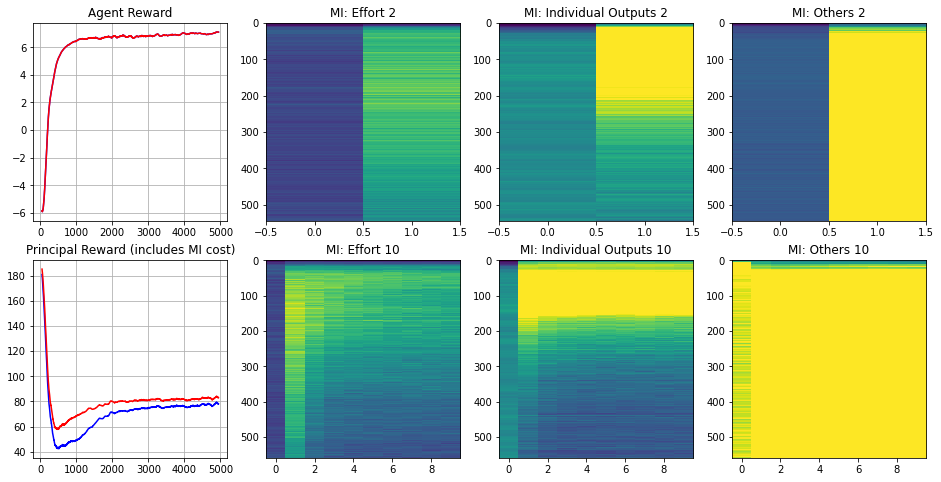

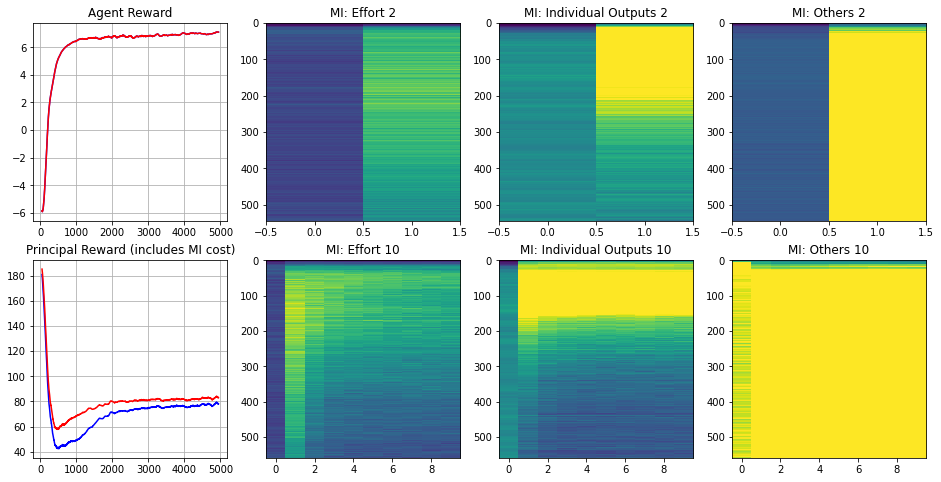

In [4]:
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

# Initialize the training history, the environment, and the principal and agent models.

hist = None
env =  PAMultiagentSignalingEnvVaryH(**vars(ns), horizons = list(range(ns.min_horizon, ns.max_horizon + 1)))

if ns.agent_arch_type == 'SQA':
    agent_pol = SoftQAgent(
        3,
        ns.n_agent_actions,
        [64, 256],
        lr=0.001,
        batch_size=512,
        buffer_size=50000,
        temp=ns.agent_entropy_coeff,  # Higher = more randomness, lower = more deterministic,
        soft=True,
        gamma=1.0
    )
else:
    agent_pol = MCCPERDPAgent(
        action_dim=ns.n_agent_actions,
        entropy_coeff=ns.agent_entropy_coeff,
        lstm_dim=32,
        action_mi_cost=ns.agent_action_mi_cost,
        channel_dicts={
            'state': dict(x_dim=4, mi_cost=ns.agent_state_mi_cost, log_std_bias=0.0),
        },
        future_rewards_only=ns.future_rewards_only,
        clip_grads = False
    )

principal_pol = MCCPERDPAgent(
    action_dim=ns.n_principal_actions, 
    n_actions=ns.n_agents,
    entropy_coeff=ns.principal_entropy_coeff,
    lstm_dim=32,
    action_mi_cost=ns.principal_action_mi_cost,
    channel_dicts={
        'last_effort': dict(x_dim=ns.n_agents, mi_cost=effort_mi_lambda, log_std_bias=0.0),
        'last_individual_outputs': dict(x_dim=int(ns.n_agents), mi_cost=output_mi_lambda, log_std_bias=0.0),
        'last_wage_hours_output_time': dict(x_dim=int(2*ns.n_agents + 3), mi_cost=ns.principal_others_mi_cost),
    },
    future_rewards_only=ns.future_rewards_only,
    clip_grads = False
)

# Perform training, and update plots periodically
plot_every = 100
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
n_rounds = int(ns.n_timesteps/plot_every + 0.5)
for _ in range(n_rounds):
    hist = train(
        principal_pol,
        agent_pol,
        env,
        n_iters=plot_every,
        hist=hist,
        normalize_t=ns.normalize_t,
        plot=True
    )
    plot_hist_signaling_vary_h(hist, axes=axes, plot_smoothed_only = True)
    
    display.clear_output(wait=True)
    display.display(fig)

### Save principal and agent

After running the above cells, you can save the principal and agent models for downstream analysis and/or further training.

**Note.** If you have already saved objects in ```ns.folder``` (see the config file) with the same hyperparameters (mi lambdas) and random seed, *this will overwrite*.

In [ ]:
if not os.path.isdir(ns.folder):
    os.makedirs(ns.folder)

save_str = get_savestr_allh(
    **vars(ns),
    principal_effort_mi_cost=effort_mi_lambda,
    principal_output_mi_cost=output_mi_lambda
) + f'_seed{random_seed}'

agent_pol.save_model(save_str + '_agent.pt')

principal_pol.save_model(save_str + '_principal.pt')

print('Saved principal and agent models in:\n\t{}'.format(save_str))